In [1]:
import numpy as np
import pandas as pnd
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
import os
import seaborn as sns

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from sklearn.metrics import confusion_matrix

#load data
dataset = 1
match dataset:
    case 1:
        test = 'fashion-mnist_test.csv'
        train = 'fashion-mnist_train.csv'
    case 2: 
        test = "mnist_test.csv"
        train = "mnist_train.csv"
testdata = pnd.read_csv(test)
traindata = pnd.read_csv(train)

#split into images and labels
testdata_pixel = testdata.drop(testdata.columns[0], axis=1).to_numpy()
traindata_pixel = traindata.drop(traindata.columns[0], axis=1).to_numpy()
label_train = traindata[traindata.columns[0]].to_numpy()
label_test = testdata[testdata.columns[0]].to_numpy()
og_label_train = label_train.copy()
og_label_test = label_test.copy()

#reshape for cnn
cnn_test = testdata_pixel.reshape(-1,28,28) /255.0
cnn_train = traindata_pixel.reshape(-1,28,28) /255.0
cnn_test = np.expand_dims(cnn_test,axis=3)
cnn_train = np.expand_dims(cnn_train,axis=3)
cnn_label_test = tf.keras.utils.to_categorical(label_test)
cnn_label_train = tf.keras.utils.to_categorical(label_train)

softmax_nodes = 10
class_names = np.array(["T-shirt / Top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"])

#summarize the classes 0 and 6
summarize_shirt = False
if summarize_shirt == True:
    label_test[label_test==6]=0
    label_test[label_test>=7]-=1
    label_train[label_train==6]=0
    label_train[label_train>=7]-=1
    cnn_label_test = tf.keras.utils.to_categorical(label_test)
    cnn_label_train = tf.keras.utils.to_categorical(label_train)
    softmax_nodes -= 1
    class_names = np.delete(class_names,6)

    shirts_pixel = traindata_pixel[(og_label_train==6)|(og_label_train==0)]
    shirts_pixel = shirts_pixel.reshape(-1,28,28) /255.0
    shirts_pixel = np.expand_dims(shirts_pixel,axis=3)
    label_shirts = og_label_train[(og_label_train==6)|(og_label_train==0)]
    label_shirts[label_shirts==6]=1
    label_shirts = tf.keras.utils.to_categorical(label_shirts)

    shirts_pixel_val = testdata_pixel[(og_label_test==6)|(og_label_test==0)]
    shirts_pixel_val = shirts_pixel_val.reshape(-1,28,28) /255.0
    shirts_pixel_val = np.expand_dims(shirts_pixel_val,axis=3)
    label_shirts_val = og_label_test[(og_label_test==6)|(og_label_test==0)].copy()
    label_shirts_val[label_shirts_val==6]=1
    label_shirts_val = tf.keras.utils.to_categorical(label_shirts_val)


1/1 [==============================] - 1s 848ms/step
T-shirt / Top: 0.0
Trouser: 0.0
Pullover: 0.0
Dress: 0.0
Coat: 0.0
Sandal: 0.998
Shirt: 0.0
Sneaker: 0.0
Bag: 0.002
Ankle Boot: 0.0


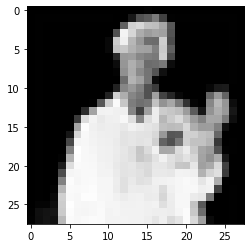

In [2]:
from PIL import Image
import numpy as np

def convert_image_to_grayscale(image_path):
    # Open the image
    image = Image.open(image_path).convert('L')  # Convert to grayscale

    # Resize the image to 28x28 pixels
    resized_image = image.resize((28, 28))

    # Convert the image to a NumPy array
    numpy_image = np.array(resized_image)

    # Normalize intensity values between 0 and 255
    normalized_image = (numpy_image / np.max(numpy_image)) * -255

    # Convert intensity values to integers
    final_image = normalized_image.astype(np.uint8)

    return final_image
your_image = "Plots/baschti.jpg"
your_image = convert_image_to_grayscale(your_image)
plt.imshow(your_image,cmap="gray")
plt.savefig('Plots/baschti.svg',format="svg")
your_image = your_image.reshape(-1,28,28) / 255.0
your_image = np.expand_dims(your_image,axis=3)
model = tf.keras.models.load_model('Results/model_shirts_notsum')
for i,prob in enumerate(np.round(model.predict(your_image)[0],3)):
    print(str(class_names[i])+": " + str(prob))

We have now loaded and reshaped the data. The labels were converted into 10-dimensional to be compatible with the output of the softmax activation function and the dimension of the images was increased by one to show that there is only one color channel. 

In [2]:
lenet5_model = Sequential([
  Conv2D(6, 5, input_shape=(28, 28, 1), activation="relu",padding="same"),
  MaxPooling2D(pool_size=2,strides=2),
  Conv2D(16, 5, activation="relu",padding="valid"),
  MaxPooling2D(pool_size=2,strides=2),
  Conv2D(120, 5, activation="relu",padding="valid"),
  Flatten(),
  Dense(84,activation="relu"),
  Dense(softmax_nodes, activation='softmax'),
])
lenet5_model.compile(
  'adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)
lenet5_model.fit(
  cnn_train,
  cnn_label_train,
  epochs=20,
  validation_data=(cnn_test, cnn_label_test)
)

Epoch 1/20
1110/1875 [================>.............] - ETA: 9s - loss: 0.5185 - accuracy: 0.8086

KeyboardInterrupt: 

In [6]:
lenet5_model.evaluate(cnn_test,cnn_label_test)

313/313 [==============================] - 2s 6ms/step - loss: 0.3240 - accuracy: 0.9085


[0.3240226209163666, 0.9085000157356262]

The previous code used a modifyed LeNet-5 architecture with max pooling instead of mean pooling and ReLU activation

In [7]:
vgg_model = Sequential([
  Conv2D(32, 3, input_shape=(28, 28, 1), activation="relu",padding="same"),
  Conv2D(32, 3, activation="relu",padding="same"),
  MaxPooling2D(pool_size=2,strides=2),
  BatchNormalization(),
  Conv2D(16, 3, activation="relu",padding="same"),
  Conv2D(16, 3, activation="relu",padding="same"),
  MaxPooling2D(pool_size=2,strides=2),
  BatchNormalization(),
  Conv2D(16, 3, activation="relu",padding="same"),
  Conv2D(16, 3, activation="relu",padding="same"),
  MaxPooling2D(pool_size=2,strides=2),
  BatchNormalization(),
  Conv2D(16, 3, activation="relu",padding="same"),
  Conv2D(16, 3, activation="relu",padding="same"),
  MaxPooling2D(pool_size=2,strides=1),
  BatchNormalization(),
  Conv2D(16, 3, activation="relu",padding="same"),
  Conv2D(16, 3, activation="relu",padding="same"),
  MaxPooling2D(pool_size=2,strides=1),
  BatchNormalization(),
  Flatten(),
  Dense(256,activation="relu"),
  Dropout(0.15),
  Dense(256,activation="relu"),
  Dropout(0.15),
  Dense(softmax_nodes, activation='softmax'),
])
vgg_model.compile(
  'adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)
vgg_model.fit(
  cnn_train,
  cnn_label_train,
  epochs=20,
  validation_data=(cnn_test, cnn_label_test),
  batch_size=128
)

Epoch 1/20
469/469 [==============================] - 82s 167ms/step - loss: 0.5797 - accuracy: 0.7845 - val_loss: 0.6758 - val_accuracy: 0.7476
Epoch 2/20
469/469 [==============================] - 137s 292ms/step - loss: 0.3626 - accuracy: 0.8670 - val_loss: 0.3314 - val_accuracy: 0.8734
Epoch 3/20
469/469 [==============================] - 147s 313ms/step - loss: 0.3150 - accuracy: 0.8846 - val_loss: 0.3066 - val_accuracy: 0.8848
Epoch 4/20
469/469 [==============================] - 121s 257ms/step - loss: 0.2808 - accuracy: 0.8974 - val_loss: 0.2882 - val_accuracy: 0.8911
Epoch 5/20
469/469 [==============================] - 131s 279ms/step - loss: 0.2594 - accuracy: 0.9050 - val_loss: 0.2667 - val_accuracy: 0.9003
Epoch 6/20
469/469 [==============================] - 152s 323ms/step - loss: 0.2501 - accuracy: 0.9094 - val_loss: 0.2991 - val_accuracy: 0.8926
Epoch 7/20
469/469 [==============================] - 152s 324ms/step - loss: 0.2353 - accuracy: 0.9140 - val_loss: 0.2592 - 

In [3]:
complex_model = Sequential([
  Conv2D(16, 5, input_shape=(28, 28, 1), activation="relu",padding="same"),
  Conv2D(16, 5, activation="relu",padding="same"),
  MaxPooling2D(pool_size=2,strides=2),
  BatchNormalization(),
  Conv2D(32, 3, activation="relu",padding="same"),
  Conv2D(32, 3, activation="relu",padding="same"),
  MaxPooling2D(pool_size=2,strides=2),
  BatchNormalization(),
  Conv2D(64, 3, activation="relu",padding="same"),
  Conv2D(64, 3, activation="relu",padding="same"),
  MaxPooling2D(pool_size=2,strides=2),
  BatchNormalization(),
  Conv2D(64, 3, activation="relu",padding="same"),
  Conv2D(64, 3, activation="relu",padding="same"),
  Conv2D(64, 3, activation="relu",padding="same"),
  MaxPooling2D(pool_size=2,strides=1),
  BatchNormalization(),
  Flatten(),
  Dense(256,activation="relu"),
  Dropout(0.1),
  Dense(512,activation="relu"),
  Dropout(0.1),
  Dense(softmax_nodes, activation='softmax'),
])
complex_model.compile(
  'adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)
tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    min_delta=0.01,
    patience=2,
    verbose=0,
    mode='auto',
    restore_best_weights=True,
    start_from_epoch=0
)
history = complex_model.fit(
  cnn_train,
  cnn_label_train,
  epochs = 5,
  validation_data=(cnn_test, cnn_label_test),
  batch_size=256
)

Epoch 1/5
235/235 [==============================] - 154s 631ms/step - loss: 0.3968 - accuracy: 0.8572 - val_loss: 2.1812 - val_accuracy: 0.3373
Epoch 2/5
235/235 [==============================] - 139s 591ms/step - loss: 0.2423 - accuracy: 0.9136 - val_loss: 0.3707 - val_accuracy: 0.8673
Epoch 3/5
235/235 [==============================] - 97s 414ms/step - loss: 0.2033 - accuracy: 0.9269 - val_loss: 0.2050 - val_accuracy: 0.9276
Epoch 4/5
235/235 [==============================] - 95s 405ms/step - loss: 0.1773 - accuracy: 0.9373 - val_loss: 0.2201 - val_accuracy: 0.9267
Epoch 5/5
235/235 [==============================] - 130s 555ms/step - loss: 0.1605 - accuracy: 0.9422 - val_loss: 0.2185 - val_accuracy: 0.9269


In [12]:
complex_model.save('Results/deep_model')

INFO:tensorflow:Assets written to: Results/deep_model\assets


INFO:tensorflow:Assets written to: Results/deep_model\assets


In [8]:
model = tf.keras.models.load_model('Results/complex_model')
y_pred = model.predict(cnn_test)
y_pred = np.argmax(y_pred,axis=1)
conf = sklearn.metrics.confusion_matrix(y_pred, label_test)
conf_df = pnd.DataFrame(conf, index=class_names, columns=class_names)
rowsums = conf_df.sum(axis=1)
acc = np.sum(y_pred == label_test)/ len(label_test)

# for i in range(10):
#     for j in range(10):
#         if i != j:
#             conf_df.values[i,j] -= (1-acc)*rowsums[i]/9
#             conf_df.values[i,j] *= -1
#         else: 
#             conf_df.values[i,j] -= acc*rowsums[i]
# sns.heatmap(conf_df, annot=True, cmap= "RdBu", annot_kws={"fontsize":6},fmt=",.1f",center=0,vmax=250,vmin=-250)
# #plt.savefig('cnn_chi.png',dpi=600)
# import visualkeras 
# visualkeras.layered_view(model)

313/313 [==============================] - 4s 11ms/step


IndexError: index 9 is out of bounds for axis 1 with size 9

In [5]:
lenet5_shirt_model = Sequential([
  Conv2D(6, 5, input_shape=(28, 28, 1), activation="relu",padding="same"),
  MaxPooling2D(pool_size=2,strides=2),
  Conv2D(16, 5, activation="relu",padding="valid"),
  MaxPooling2D(pool_size=2,strides=2),
  Conv2D(120, 5, activation="relu",padding="valid"),
  Flatten(),
  Dense(84,activation="relu"),
  Dense(2, activation='softmax'),
])
lenet5_shirt_model.compile(
  'adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)
lenet5_shirt_model.fit(
  shirts_pixel,
  label_shirts,
  epochs=75,
  validation_data = (shirts_pixel_val,label_shirts_val),
  batch_size = 256
)

Epoch 1/75
47/47 [==============================] - 6s 85ms/step - loss: 0.4683 - accuracy: 0.7942 - val_loss: 0.4009 - val_accuracy: 0.8045
Epoch 2/75
47/47 [==============================] - 3s 72ms/step - loss: 0.3588 - accuracy: 0.8357 - val_loss: 0.3644 - val_accuracy: 0.8370
Epoch 3/75
47/47 [==============================] - 3s 74ms/step - loss: 0.3381 - accuracy: 0.8487 - val_loss: 0.3603 - val_accuracy: 0.8390
Epoch 4/75
47/47 [==============================] - 3s 69ms/step - loss: 0.3282 - accuracy: 0.8525 - val_loss: 0.3387 - val_accuracy: 0.8490
Epoch 5/75
47/47 [==============================] - 3s 68ms/step - loss: 0.3083 - accuracy: 0.8628 - val_loss: 0.3423 - val_accuracy: 0.8325
Epoch 6/75
47/47 [==============================] - 3s 67ms/step - loss: 0.3072 - accuracy: 0.8626 - val_loss: 0.3230 - val_accuracy: 0.8520
Epoch 7/75
47/47 [==============================] - 3s 69ms/step - loss: 0.2857 - accuracy: 0.8713 - val_loss: 0.3213 - val_accuracy: 0.8520
Epoch 8/75
47

68/68 [==============================] - 0s 6ms/step
0.9037
1174
               T-shirt / Top  Trouser  Pullover  Dress  Coat  Sandal  Shirt   
T-shirt / Top            839        2        35     16     0       0    100  \
Trouser                    4      986         0      9     2       0      0   
Pullover                   3        1       741      1    28       0     20   
Dress                     15        8        15    914    25       0     24   
Coat                       0        0        88     23   864       0     35   
Sandal                     0        0         0      0     0     952      0   
Shirt                    132        3       116     29    77       0    813   
Sneaker                    0        0         0      0     0      41      0   
Bag                        7        0         5      7     4       1      8   
Ankle Boot                 0        0         0      1     0       6      0   

               Sneaker  Bag  Ankle Boot  
T-shirt / Top        0 

<AxesSubplot:>

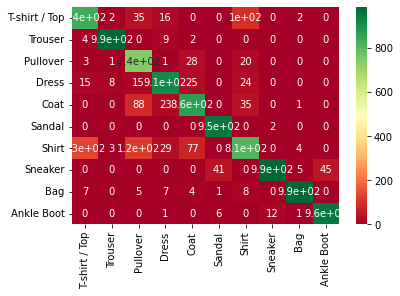

In [64]:

predictions = complex_model.predict(cnn_test)
predictions =np.argmax(predictions, axis=1)
predictions[predictions>=6]+=1
prediction_shirt = cnn_test[predictions==0]
prediction_shirt_final = lenet5_shirt_model.predict(prediction_shirt)
prediction_shirt_final = np.argmax(prediction_shirt_final,axis=1) 
index = np.where(predictions==0)[0]
for i in range(np.sum(predictions==0)):
    if prediction_shirt_final[i]==1:
        predictions[index[i]] = 6
print(np.sum(predictions==og_label_test)/len(og_label_test))
print(np.sum(predictions==6))
y_pred = predictions
y_true = og_label_test #label seems to be wrong
class_names = np.array(["T-shirt / Top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"])
conf = confusion_matrix(y_pred, y_true)
conf_df = pnd.DataFrame(conf, index=class_names, columns=class_names)
print(conf_df)
sns.heatmap(conf_df, annot=True, cmap='RdYlGn')